In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [4]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import matplotlib.cm as pltcm

import scipy

import cx_rate
import trials
import plotter
import bee_simulator

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

In [70]:
def colorbar(mappable, title=''):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.03)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar

In [6]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


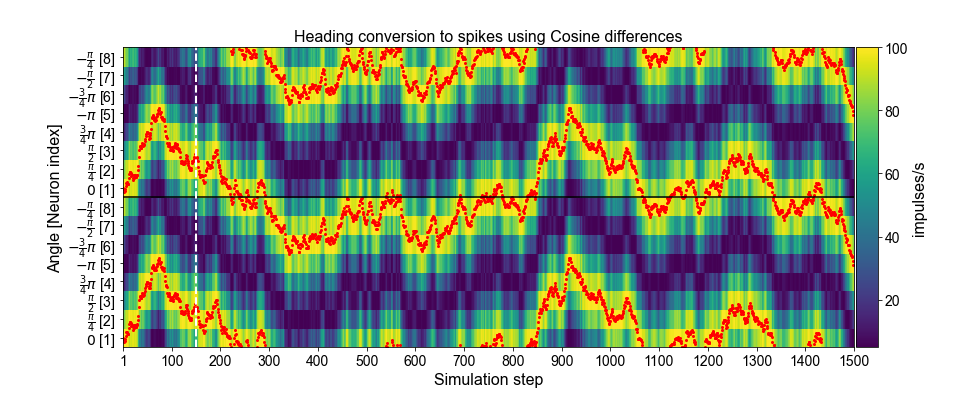

In [123]:
# Heading plot
fontsize=16

headings_cos  = cx_spiking.inputs.compute_cos_headings(h, N=N_TL2, vmin=5, vmax=100)
plt.figure(figsize=(15,6))
plt.plot((h[:T_outbound] * 4 / np.pi + 0.5) % 8 , '.r', markersize=4)
plt.plot((h[:T_outbound] * 4 / np.pi + 0.5) % 8 + 8 , '.r', markersize=4)

plt.axhline(8, color='k')

p = plt.pcolormesh(headings_cos[:T_outbound,:].T, rasterized=True)

plt.axvline(150, color='w', ls='--', lw=2, alpha=1)

indexes = np.arange(1, N_TL2+1)
angles = [r'$0$', r'$\frac{\pi}{4}$',  r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', 
                r'$-\pi$', r'$-\frac{3}{4}\pi$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$']
merged = [f'{a} [{i}]' for i,a in zip(indexes, angles)] + [f'{a} [{i}]' for i,a in zip(indexes, angles)]

plt.xlabel('Simulation step', fontsize=fontsize)
plt.xticks(np.arange(0, T_outbound+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=fontsize-2)
plt.ylabel('Angle [Neuron index]', fontsize=fontsize)
plt.yticks(np.arange(0, N_TL2) + 0.5, merged, fontsize=fontsize-2)
cx_spiking.plotting.colorbar(p, 'impulses/s', fontsize=fontsize)
plt.title(f'Heading conversion to spikes using Cosine differences', fontsize=fontsize)
#plt.tight_layout()

plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/heading_cos.pdf'),
            bbox_inches='tight')
plt.show()


# plt.figure(figsize=(15,6))

# plt.plot((h * 4 / np.pi + 0.5) % 8 , '.r', markersize=4)
# plt.plot((h * 4 / np.pi + 0.5) % 8 + 8 , '.r', markersize=4)

# plt.axhline(8, color='r')

# p = plt.pcolormesh(headings[:T_outbound,:].T, rasterized=True)

# plt.xlabel('Simulation step')
# plt.ylabel('Neuron index')
# plt.yticks(np.arange(0, N_TL2) + 0.5, np.arange(1, N_TL2+1))

# colorbar(p, 'impulses/s')

# plt.title('Heading conversion to spikes using von Mises')

# plt.tight_layout()

# plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/heading.pdf'))
# plt.show()


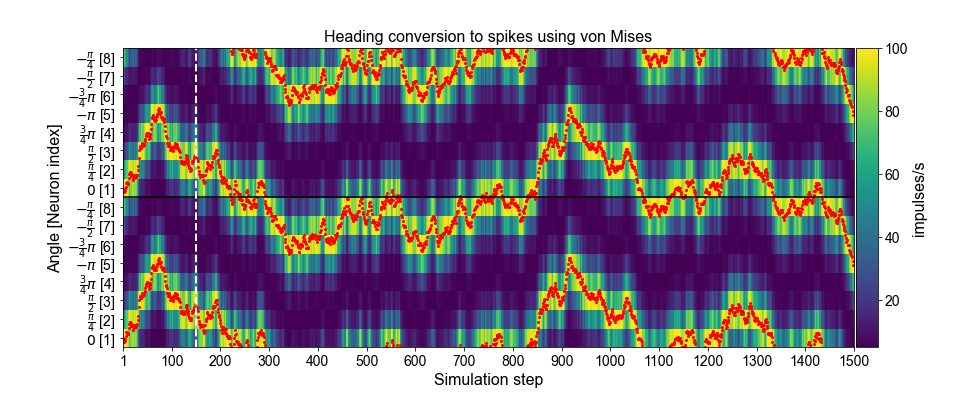

In [124]:
# Heading plot


plt.figure(figsize=(15,6))
plt.plot((h[:T_outbound] * 4 / np.pi + 0.5) % 8 , '.r', markersize=4)
plt.plot((h[:T_outbound] * 4 / np.pi + 0.5) % 8 + 8 , '.r', markersize=4)

plt.axhline(8, color='k')

p = plt.pcolormesh(headings[:T_outbound,:].T, rasterized=True)

plt.axvline(150, color='w', ls='--', lw=2, alpha=1)

indexes = np.arange(1, N_TL2+1)
angles = [r'$0$', r'$\frac{\pi}{4}$',  r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', 
                r'$-\pi$', r'$-\frac{3}{4}\pi$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$']
merged = [f'{a} [{i}]' for i,a in zip(indexes, angles)] + [f'{a} [{i}]' for i,a in zip(indexes, angles)]

plt.xlabel('Simulation step', fontsize=fontsize)
plt.xticks(np.arange(0, T_outbound+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=fontsize-2)
plt.ylabel('Angle [Neuron index]', fontsize=fontsize)
plt.yticks(np.arange(0, N_TL2) + 0.5, merged, fontsize=fontsize-2)
cx_spiking.plotting.colorbar(p, 'impulses/s', fontsize=fontsize)
plt.title(f'Heading conversion to spikes using von Mises', fontsize=fontsize)
#plt.tight_layout()

plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/heading.pdf'),
            bbox_inches='tight')
plt.show()



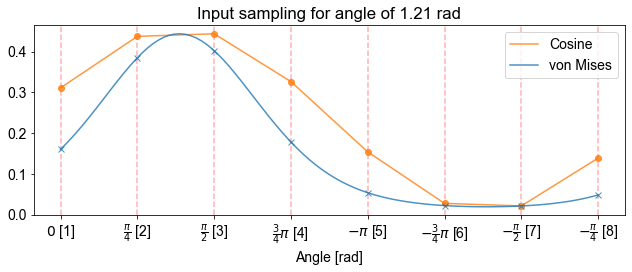

In [115]:
mu = 0
sigma = 0.8
angle_index = 150

# rv = scipy.stats.norm(loc=mu, scale=sigma)
# x = np.linspace(mu - np.pi, mu + np.pi, 100)

# mu2 = np.pi/4
# kappa = 1. / sigma**2
# rv2 = scipy.stats.vonmises(mu, kappa)
x = np.linspace(0, 2* np.pi -np.pi/4, 100)
tl2_prefs = np.linspace(0, 2*np.pi, 8, endpoint=False)

plt.figure(figsize=(9,4))


for i in np.linspace(0, 2*np.pi, 8, endpoint=False):
    plt.axvline(i, color='r', ls='--', alpha=0.3)

N = 8
xs = np.linspace(0, 2*np.pi, N+1, endpoint=True)
samples = scipy.stats.vonmises.pdf(xs, kappa, loc=h[angle_index])

plt.plot(xs[:N], cx_spiking.inputs.normalise_range(np.cos(h[angle_index] - tl2_prefs)+1, vmin=samples[:N].min(), vmax=scipy.stats.vonmises.pdf(h[angle_index], kappa, loc=h[angle_index])), 
         label='Cosine', color='tab:orange', alpha=0.8)
plt.plot(xs[:N], cx_spiking.inputs.normalise_range(np.cos(h[angle_index] - tl2_prefs)+1, vmin=samples[:N].min(), vmax=scipy.stats.vonmises.pdf(h[angle_index], kappa, loc=h[angle_index])),
         'o', color='tab:orange', alpha=0.8)

plt.plot(x, scipy.stats.vonmises.pdf(x, kappa, loc=h[angle_index]), label='von Mises', color='tab:blue', alpha=0.8)
plt.plot(xs[:N], samples[:N], 'x', color='tab:blue', alpha=0.8)



plt.xticks(xs[:N], [r'$0$ [1]', r'$\frac{\pi}{4}$ [2]',  r'$\frac{\pi}{2}$ [3]', r'$\frac{3}{4}\pi$ [4]', 
                r'$-\pi$ [5]', r'$-\frac{3}{4}\pi$ [6]', r'$-\frac{\pi}{2}$ [7]', r'$-\frac{\pi}{4}$ [8]'])
plt.xlabel('Angle [rad]')
#plt.ylabel('VonMises')
plt.title(f'Input sampling for angle of {h[angle_index]:.2f} rad')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/vonmises.pdf'))#, bbox='tight_layout')

plt.show()

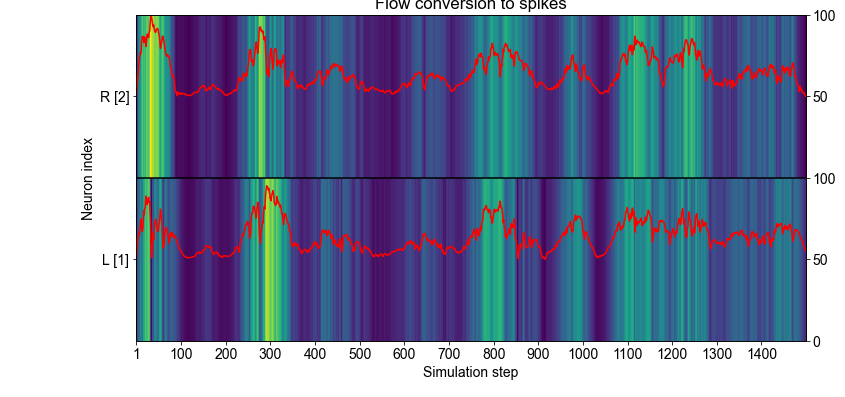

In [88]:
#plt.figure(figsize=(15,6))
fig, ax1 = plt.subplots(figsize=(15,6))

ax2 = ax1.twinx()

ax1.plot(flow[:T_outbound,0] /100, 'r')
ax1.plot(flow[:T_outbound,1] /100+1, 'r')
ax1.axhline(1, color='k')
ax1.set_xlabel('Simulation step')
ax1.set_xticks(np.arange(0, T_outbound+1, 100) + 0.5 )
ax1.set_xticklabels([1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500])
ax1.set_ylabel('Neuron index')
ax1.set_yticks(np.arange(0, N_TN2) + 0.5)
ax1.set_yticklabels(['L [1]', 'R [2]'])

#ax2.set_ylabel('Hz')
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_yticklabels(['0', '50', '100', '50', '100'])

p = ax1.pcolormesh(flow[:T_outbound,:].T, rasterized=True)

cbar = fig.colorbar(p, orientation="vertical", pad=0.05)
cbar.set_label('impulses/s')
#colorbar(p, 'impulses/s')
plt.title('Flow conversion to spikes')
#plt.tight_layout()

plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/flow.pdf'),
           bbox_inches='tight')
plt.show()




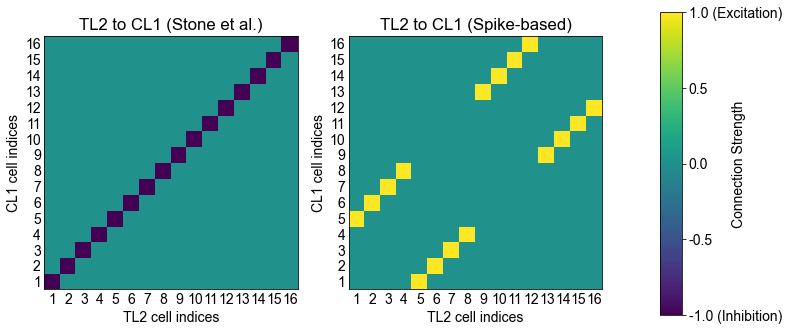

In [60]:
# TL2 to CL1 connectivity matrices

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
weights_rate = -np.eye(N_CL1)
p1 = ax[0].pcolor(weights_rate, cmap='viridis', vmin=-1, vmax=1)
p1.set_edgecolor('face')
ax[0].set_aspect('equal')
ax[0].set_xticks(np.arange(weights_rate.shape[1]) + 0.5)
ax[0].set_xticklabels(range(1,N_CL1+1))
ax[0].set_yticks(np.arange(weights_rate.shape[0]) + 0.5)
ax[0].set_yticklabels(range(1,N_CL1+1))
ax[0].set_title('TL2 to CL1 (Stone et al.)')
ax[0].set_xlabel('TL2 cell indices')
ax[0].set_ylabel('CL1 cell indices')
ax[0].tick_params(axis=u'both', which=u'both', length=0)

weights_spike = W_TL2_CL1
p2 = ax[1].pcolor(weights_spike, cmap='viridis', vmin=-1, vmax=1)
p2.set_edgecolor('face')
ax[1].set_aspect('equal')
ax[1].set_xticks(np.arange(weights_spike.shape[1]) + 0.5)
ax[1].set_xticklabels(range(1,N_CL1+1))
ax[1].set_yticks(np.arange(weights_rate.shape[0]) + 0.5)
ax[1].set_yticklabels(range(1,N_CL1+1))
ax[1].set_title('TL2 to CL1 (Spike-based)')
ax[1].set_xlabel('TL2 cell indices')
ax[1].set_ylabel('CL1 cell indices')
ax[1].tick_params(axis=u'both', which=u'both', length=0)


cbax = fig.add_axes([0.98, 0.15, 0.03, 0.7])
m = pltcm.ScalarMappable(cmap='viridis')
m.set_array(np.linspace(-1, 1, 100))
cb = fig.colorbar(m, cbax, ticks=[-1, -0.5, 0, 0.5, 1])
cb.set_label('Connection Strength', labelpad=-50)
cb.ax.set_yticklabels(['-1.0 (Inhibition)', '-0.5', '0.0', '0.5',
                       '1.0 (Excitation)'])
#plt.tight_layout()
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/TL2_CL1.pdf'),
           bbox_inches='tight')
plt.show()

